In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats

In [2]:
df = pd.read_csv('df_nhanes.csv')

In [3]:
df.head()

,SEQN,energy,protein,carb,sugar,fiber,totalfat,satfat,monofat,polyfat,...,sodium,potassium,age,race,education,marital,income,income_mid,povertyratio,sample_result
0,93704.0,1230,51.58,160.46,76.97,5.9,43.24,11.372,14.333,12.506,...,2198,1970,2,White,NaN,NaN,100000+,112500,5.00,0
1,93705.0,1202,20.01,157.45,91.55,8.4,56.98,16.435,16.432,19.786,...,3574,1640,66,Black,SomeHighSchool,Divorced,10000-14999,12500,0.82,0
2,93707.0,1775,59.48,188.15,84.22,10.9,89.18,33.252,33.712,12.424,...,2450,1769,13,Other,NaN,NaN,65000-74999,70000,1.88,0
3,93708.0,1251,50.96,123.71,49.84,16.6,65.49,17.446,29.000,14.823,...,2135,1631,66,Asian,LessThan9th,Married,25000-34999,30000,1.63,1
4,93710.0,900,22.93,140.80,89.93,6.7,27.69,9.717,8.788,7.351,...,670,1058,0,White,NaN,NaN,100000+,112500,4.90,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6624 entries, 0 to 6623
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SEQN           6624 non-null   float64
 1   energy         6624 non-null   int64  
 2   protein        6624 non-null   float64
 3   carb           6624 non-null   float64
 4   sugar          6624 non-null   float64
 5   fiber          6624 non-null   float64
 6   totalfat       6624 non-null   float64
 7   satfat         6624 non-null   float64
 8   monofat        6624 non-null   float64
 9   polyfat        6624 non-null   float64
 10  cholesterol    6624 non-null   int64  
 11  sodium         6624 non-null   int64  
 12  potassium      6624 non-null   int64  
 13  age            6624 non-null   int64  
 14  race           6624 non-null   object 
 15  education      4156 non-null   object 
 16  marital        4156 non-null   object 
 17  income         6624 non-null   object 
 18  income_m

In [5]:
# Step 1: Define thresholds for the data-driven risk indicators

# Define "high" sugar and sat fat as the top 25% (75th percentile)
sugar_threshold = df['sugar'].quantile(0.75)
satfat_threshold = df['satfat'].quantile(0.75)

# Define "low" potassium as the bottom 25% (25th percentile)
potassium_threshold = df['potassium'].quantile(0.25)

# Step 2: Create new binary columns for each individual risk condition

df['low_fiber'] = (df['sample_result'] == 0)                     # NHANES flag: 0 = low fiber
df['high_sugar'] = (df['sugar'] > sugar_threshold)              # Top 25% sugar consumers
df['high_satfat'] = (df['satfat'] > satfat_threshold)           # Top 25% sat fat consumers
df['low_potassium'] = (df['potassium'] < potassium_threshold)   # Bottom 25% potassium intake
df['low_income'] = (df['povertyratio'] < 1.3)                   # Low income threshold

# Step 3: Count how many of the 5 risk conditions each person meets
df['risk_score'] = (
    df['low_fiber'].astype(int) +
    df['high_sugar'].astype(int) +
    df['high_satfat'].astype(int) +
    df['low_potassium'].astype(int) +
    df['low_income'].astype(int)
)

# Step 4: Define a person as "at risk" if they meet 3 or more risk conditions
df['at_risk'] = (df['risk_score'] >= 3).astype(int)

# Optional: Check class distribution
df['at_risk'].value_counts()


0    5401
1    1223
Name: at_risk, dtype: int64

In [6]:
# Show the first few rows with the new columns included
df[['sample_result', 'sugar', 'satfat', 'potassium', 'povertyratio', 
    'low_fiber', 'high_sugar', 'high_satfat', 'low_potassium', 'low_income',
    'risk_score', 'at_risk']].head()


,sample_result,sugar,satfat,potassium,povertyratio,low_fiber,high_sugar,high_satfat,low_potassium,low_income,risk_score,at_risk
0,0,76.97,11.372,1970,5.00,True,False,False,False,False,1,0
1,0,91.55,16.435,1640,0.82,True,False,False,False,True,2,0
2,0,84.22,33.252,1769,1.88,True,False,False,False,False,1,0
3,1,49.84,17.446,1631,1.63,False,False,False,False,False,0,0
4,0,89.93,9.717,1058,4.90,True,False,False,True,False,2,0


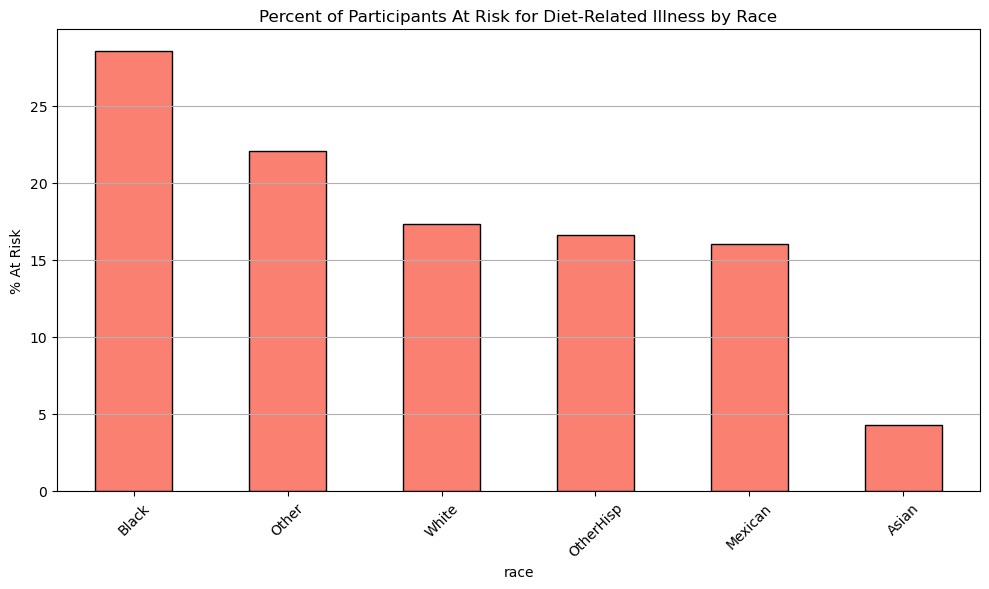

In [7]:
import matplotlib.pyplot as plt

# Group by race and at_risk, then count how many are and aren't at risk
race_risk_counts = df.groupby(['race', 'at_risk']).size().unstack(fill_value=0)

# Calculate the percent at risk for each race
race_risk_counts['% at risk'] = (
    race_risk_counts[1] / (race_risk_counts[0] + race_risk_counts[1])
) * 100

# Plot the percentage at risk as a bar chart
plt.figure(figsize=(10, 6))
race_risk_counts['% at risk'].sort_values(ascending=False).plot(
    kind='bar', 
    color='salmon', 
    edgecolor='black'
)

plt.ylabel('% At Risk')
plt.title('Percent of Participants At Risk for Diet-Related Illness by Race')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [8]:
df.to_csv("nhanes_for_tableau.csv", index=False)


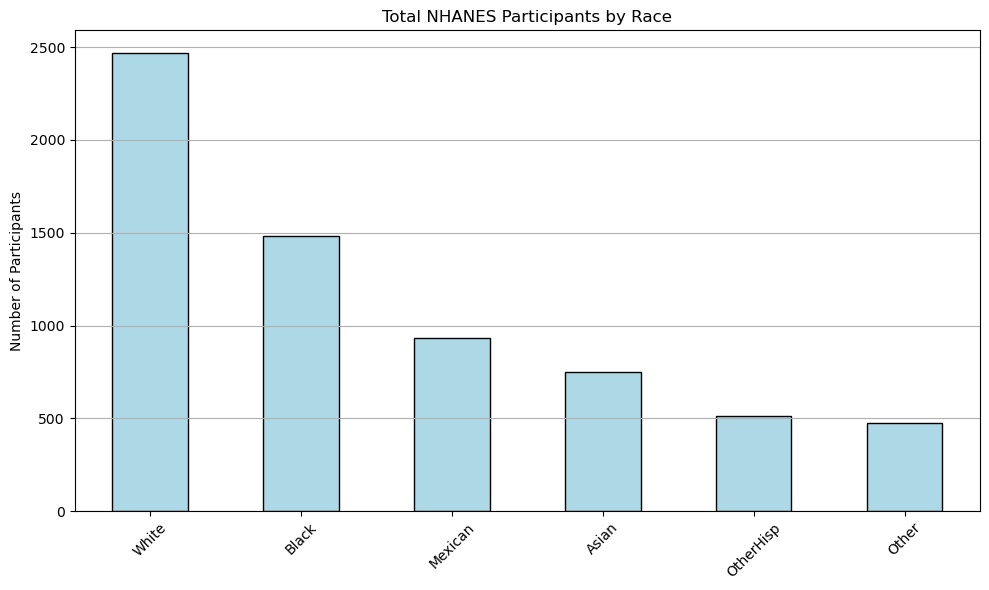

In [9]:
import matplotlib.pyplot as plt

# Count total participants by race
race_counts = df['race'].value_counts().sort_values(ascending=False)

# Plot the total number of respondents by race
plt.figure(figsize=(10, 6))
race_counts.plot(kind='bar', color='lightblue', edgecolor='black')

plt.ylabel('Number of Participants')
plt.title('Total NHANES Participants by Race')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


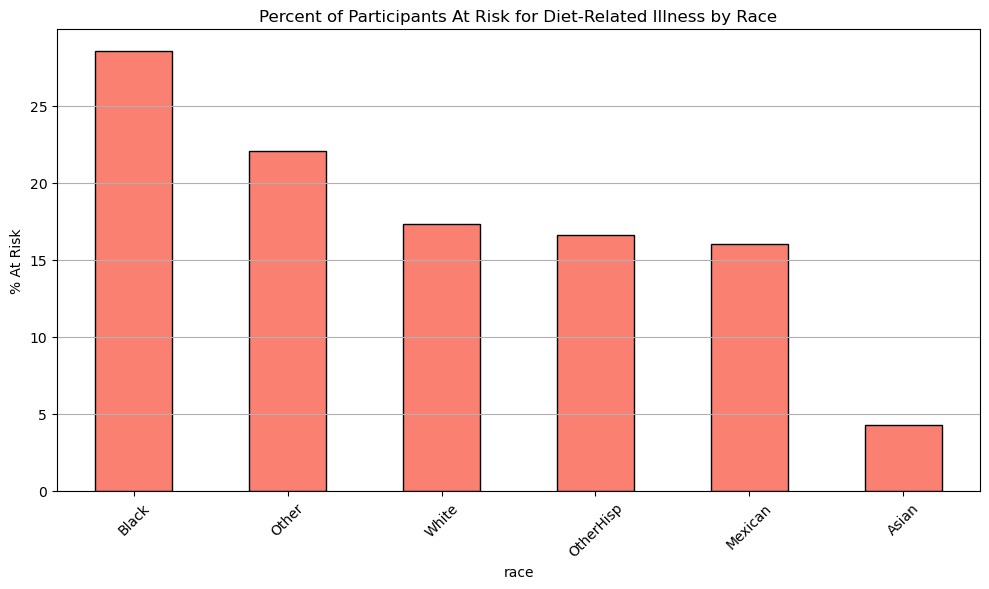

In [10]:
# Group by race and at_risk, then count how many are and aren't at risk
race_risk_counts = df.groupby(['race', 'at_risk']).size().unstack(fill_value=0)

# Calculate the percent at risk for each race
race_risk_counts['% at risk'] = (
    race_risk_counts[1] / (race_risk_counts[0] + race_risk_counts[1])
) * 100

# Plot the percentage at risk as a bar chart
plt.figure(figsize=(10, 6))
race_risk_counts['% at risk'].sort_values(ascending=False).plot(
    kind='bar', 
    color='salmon', 
    edgecolor='black'
)

plt.ylabel('% At Risk')
plt.title('Percent of Participants At Risk for Diet-Related Illness by Race')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


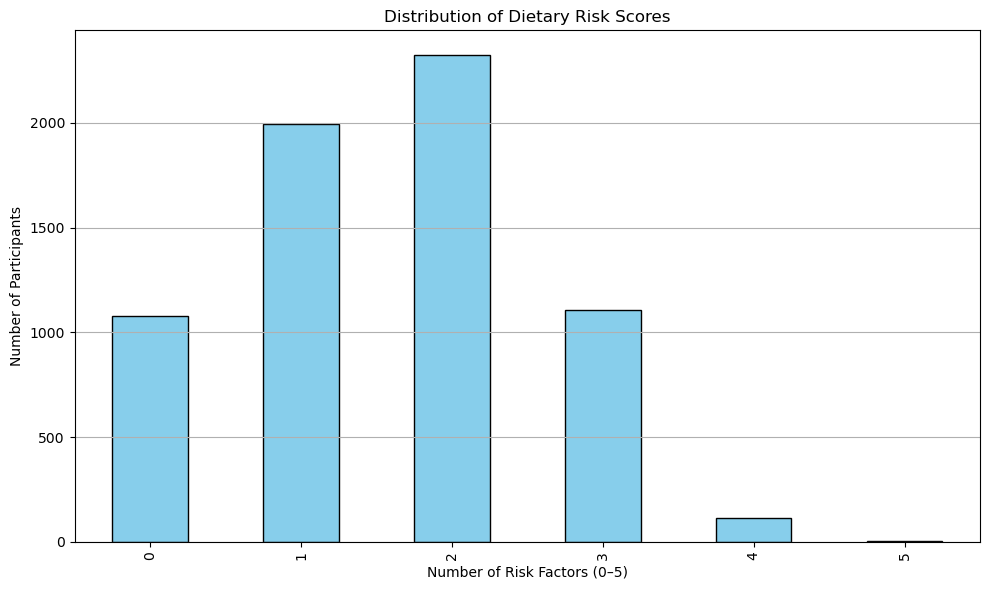

In [11]:
plt.figure(figsize=(10, 6))
df['risk_score'].value_counts().sort_index().plot(
    kind='bar', 
    color='skyblue', 
    edgecolor='black'
)

plt.xlabel('Number of Risk Factors (0–5)')
plt.ylabel('Number of Participants')
plt.title('Distribution of Dietary Risk Scores')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Select features and target
features = ['povertyratio', 'sugar', 'fiber', 'satfat', 'potassium', 'race']
X = pd.get_dummies(df[features], drop_first=True)
y = df['at_risk']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

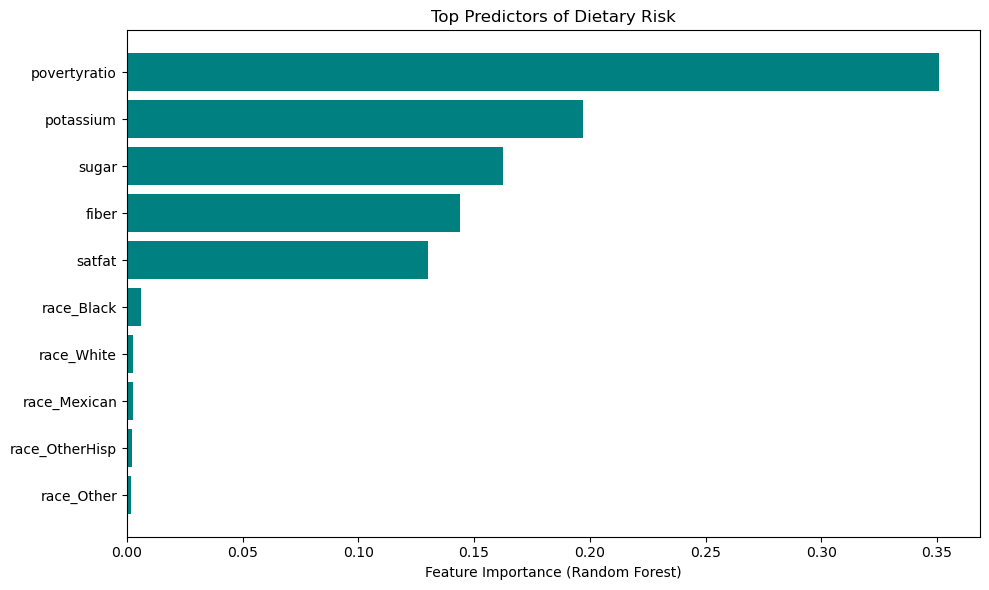

In [14]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf_model.feature_importances_
feat_names = X.columns

# Build DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.xlabel('Feature Importance (Random Forest)')
plt.title('Top Predictors of Dietary Risk')
plt.tight_layout()
plt.show()


In [ ]:
Income matters most. People with lower income were more likely to show overlapping diet-related risks. Sugar, potassium, fiber, and saturated fat also helped the model predict risk, but race alone did not explain much once income and diet were accounted for.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Select features used in your RF model
features = ['povertyratio', 'sugar', 'fiber', 'satfat', 'potassium', 'race']
X = pd.get_dummies(df[features], drop_first=True)
y = df['at_risk']

# Fit model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get importance and feature names
importances = rf_model.feature_importances_
feature_names = X.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': from scipy.stats import chi2_contingency
import pandas as pd

# Create a contingency table of race vs at_risk
contingency_table = pd.crosstab(df['race'], df['at_risk'])

# Run Chi-Square test of independence
chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)

# Show result
print("Chi-Square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-Value:", p_chi2)
importances
}).sort_values(by='Importance', ascending=False)

# Export for Tableau
importance_df.to_csv("feature_importance_for_tableau.csv", index=False)


In [19]:
from scipy.stats import chi2_contingency
import pandas as pd

# Create a contingency table of race vs at_risk
contingency_table = pd.crosstab(df['race'], df['at_risk'])

# Run Chi-Square test of independence
chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)

# Show result
print("Chi-Square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-Value:", p_chi2)


Chi-Square Statistic: 211.78717805123875
Degrees of Freedom: 5
P-Value: 8.527154174575414e-44


In [20]:
from scipy.stats import pearsonr

# Continuous features to test
features = ['sugar', 'fiber', 'satfat', 'potassium', 'povertyratio']

# Store results
for feature in features:
    corr, p_value = pearsonr(df[feature], df['at_risk'])
    print(f"{feature}: Correlation = {corr:.4f}, P-Value = {p_value:.6f}")


sugar: Correlation = 0.1716, P-Value = 0.000000
fiber: Correlation = -0.2229, P-Value = 0.000000
satfat: Correlation = 0.0662, P-Value = 0.000000
potassium: Correlation = -0.1681, P-Value = 0.000000
povertyratio: Correlation = -0.3911, P-Value = 0.000000


In [21]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['race'], df['at_risk'])

# Perform Chi-Square test
chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)

# Print the result
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p_chi2}")


Chi-Square Statistic: 211.78717805123875
P-Value: 8.527154174575414e-44


In [22]:
# Create a small DataFrame with the Chi-Square result
chi_square_result = pd.DataFrame({
    'Statistic': [chi2],
    'P-Value': [p_chi2]
})

# Export to CSV
chi_square_result.to_csv("chi_square_results.csv", index=False)


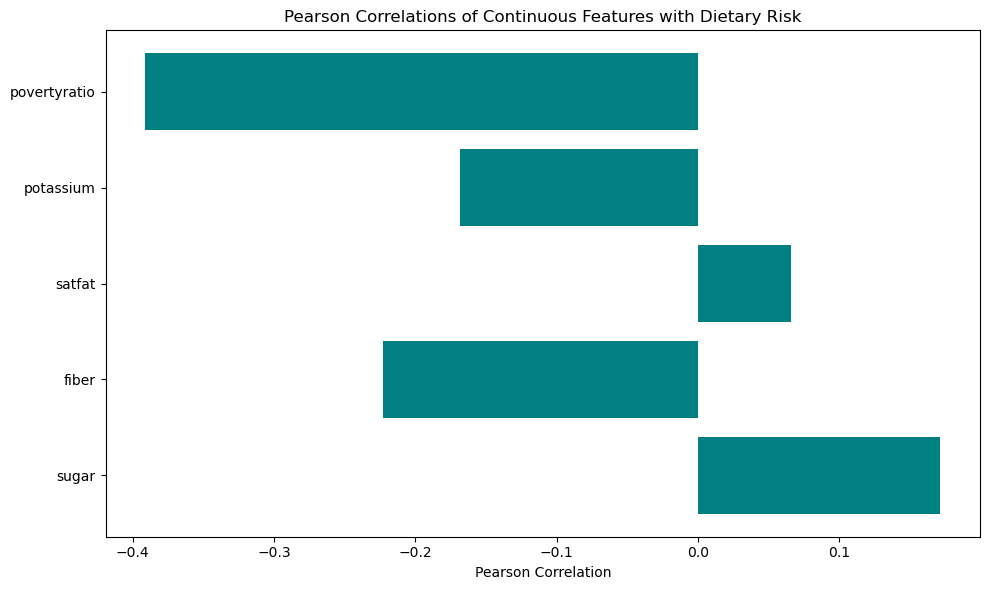

In [23]:
import matplotlib.pyplot as plt

# Pearson results (example data from earlier)
pearson_results = [
    ('sugar', 0.1716, 0.000),
    ('fiber', -0.2229, 0.000),
    ('satfat', 0.0662, 0.000),
    ('potassium', -0.1681, 0.000),
    ('povertyratio', -0.3911, 0.000)
]

# Create DataFrame for Pearson results
pearson_df = pd.DataFrame(pearson_results, columns=['Feature', 'Correlation', 'P-Value'])

# Plotting the correlation values
plt.figure(figsize=(10, 6))
plt.barh(pearson_df['Feature'], pearson_df['Correlation'], color='teal')
plt.xlabel('Pearson Correlation')
plt.title('Pearson Correlations of Continuous Features with Dietary Risk')
plt.tight_layout()
plt.show()



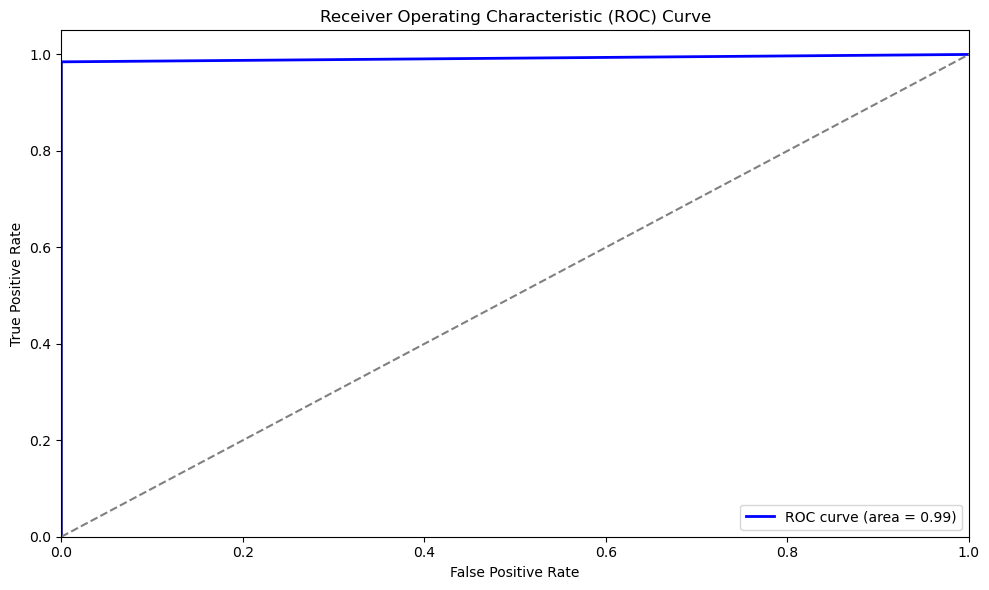

In [24]:
from sklearn.metrics import roc_curve, auc

# Generate predictions for the test set
y_pred = rf_model.predict(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


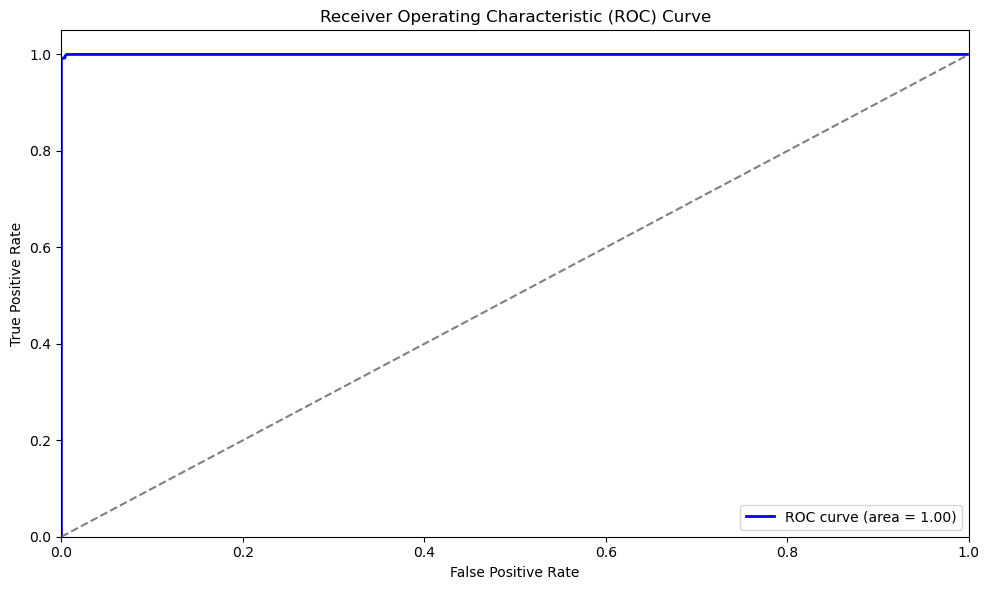

In [25]:
from sklearn.metrics import roc_curve, auc

# Generate probability predictions for the test set
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
